In [16]:
import pandas as pd
import numpy as np
from faker import Faker
import shutil

fake = Faker()


def generate_student_data(n_students=200):
    data = []
    for i in range(n_students):
        gender = np.random.choice(["male", "female"])
        immigrant_status = np.random.choice(["non-immigrant", "1st-gen", "2nd-gen"], p=[0.6, 0.2, 0.2])
        ses = np.clip(np.random.normal(loc=5, scale=2), 0, 10)
        achievement = np.clip(np.random.normal(loc=70, scale=15), 0, 100)

        # Assign psychological distress: higher risk for female, low-SES, low-achievement, immigrants
        distress_risk = 0
        if gender == "female": distress_risk += 1
        if ses < 4: distress_risk += 1
        if achievement < 60: distress_risk += 1
        if immigrant_status != "non-immigrant": distress_risk += 1
        psychological_distress = 1 if distress_risk >= 2 else 0


        data.append([i+1, gender, immigrant_status, round(ses, 1), round(achievement, 1),
                     psychological_distress])

    df = pd.DataFrame(data, columns=[
        "student_id", "gender", "immigrant_status", "SES", "achievement",
        "psychological_distress"
    ])
    return df


df_students = generate_student_data()
df_students.head()
df_students.to_csv('/tmp/student_dataset.csv', index=False)
# Move to the root directory to appear in the file browser
shutil.move("/tmp/student_dataset.csv", "student_dataset.csv")
df_students.head()


,student_id,gender,immigrant_status,SES,achievement,psychological_distress
0,1,female,2nd-gen,6.3,93.0,1
1,2,male,1st-gen,3.0,60.1,1
2,3,female,non-immigrant,5.9,53.2,1
3,4,male,1st-gen,6.7,59.6,1
4,5,female,1st-gen,5.2,78.7,1


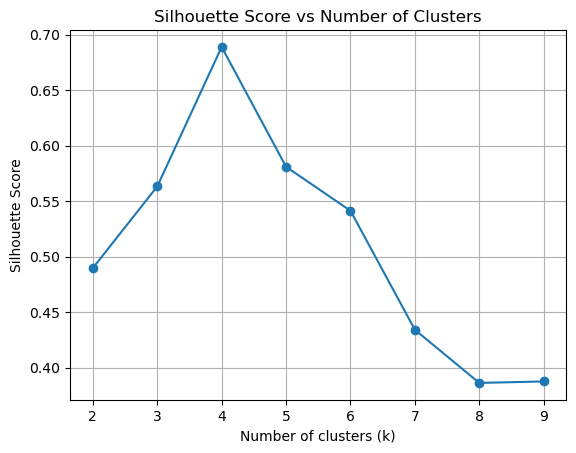

Best number of blocks (clusters): 4
Saved clustered data to students_with_blocks.csv
[40, 73, 61, 26]


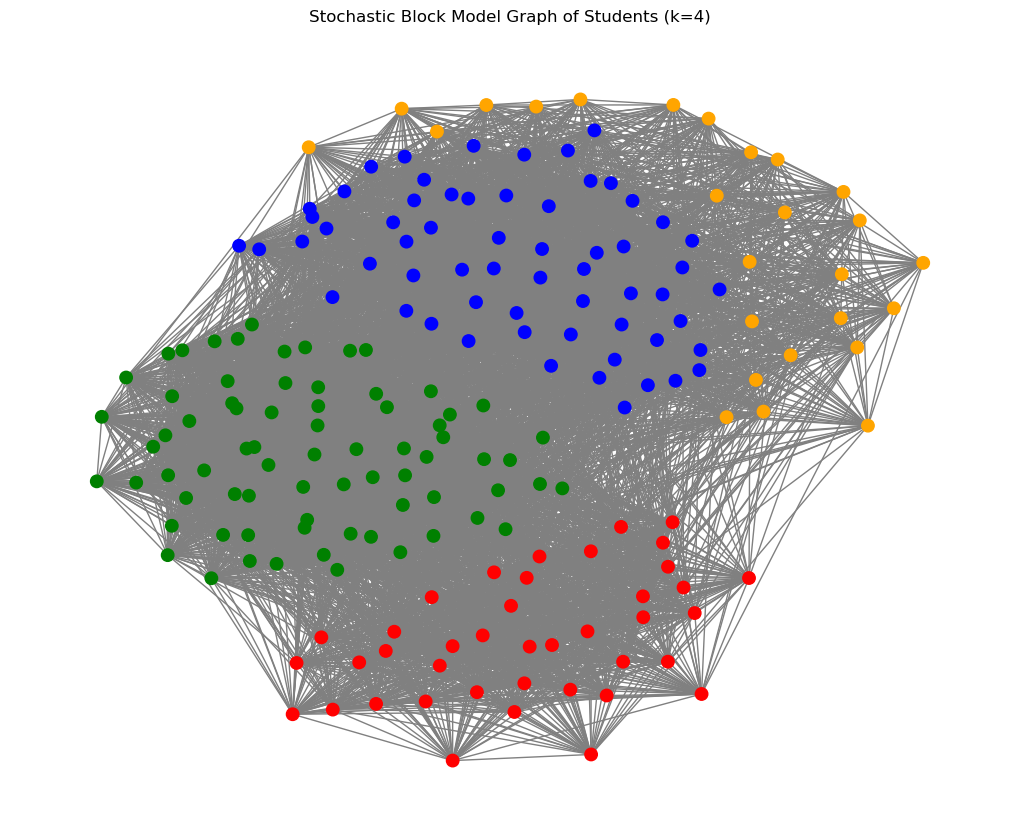

In [18]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

# Load the data
df = pd.read_csv("student_dataset.csv")

# Normalize numerical features for similarity calculation
scaler = MinMaxScaler()
numerical_features = df[["SES", "achievement", "psychological_distress"]]
normalized_features = scaler.fit_transform(numerical_features)
normalized_features = pd.DataFrame(normalized_features)

# Combine all features
combined_features = pd.concat([
    pd.DataFrame(normalized_features),
    df['gender'].map({'male': 0, 'female': 1})
], axis=1)
combined_features.columns = ['SES', 'achievement', 'psychological_distress', 'gender_code']

scaler = MinMaxScaler()
X_processed = scaler.fit_transform(combined_features)

# === Step 4: Find optimal number of clusters using silhouette score ===
silhouette_scores = []
K_range = range(2, 10)  # Try 2 to 9 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_processed)
    score = silhouette_score(X_processed, labels)
    silhouette_scores.append(score)

# Plot scores to help decide
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# === Step 5: Choose best k based on max silhouette score ===
best_k = K_range[np.argmax(silhouette_scores)]
print(f"Best number of blocks (clusters): {best_k}")

# === Step 6: Final clustering with best_k ===
final_kmeans = KMeans(n_clusters=best_k, random_state=42)
df['block'] = final_kmeans.fit_predict(X_processed)


# === Step 7: Save with blocks ===
df.to_csv("students_with_blocks.csv", index=False)
combined_features.to_csv("normalized_data.csv", index = False)
print("Saved clustered data to students_with_blocks.csv")


block_labels = df['block'].values
n = len(df)
k = 4  # number of blocks
P = np.array([[0.8, 0.2, 0.1, 0.1],
              [0.2, 0.7, 0.2, 0.1],
              [0.1, 0.2, 0.6, 0.3],
              [0.1, 0.1, 0.3, 0.5]])

# === Organize students into blocks ===
blocks = [np.where(block_labels == i)[0] for i in range(k)]
block_sizes = [len(b) for b in blocks]
print(block_sizes)

# === Generate adjacency matrix based on SBM ===
adj_matrix = np.zeros((n, n))

for i in range(k):
    for j in range(k):
        for u in blocks[i]:
            for v in blocks[j]:
                if u < v:  # only fill upper triangle (undirected graph)
                    if np.random.rand() < P[i, j]:
                        adj_matrix[u, v] = 1
                        adj_matrix[v, u] = 1

# === Create graph from adjacency matrix ===
G = nx.from_numpy_array(adj_matrix)

# === Visualization ===
color_map = ['red', 'green', 'blue', 'orange']
colors = [color_map[block_labels[i]] for i in range(n)]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=80, edge_color='gray')
plt.title("Stochastic Block Model Graph of Students (k=4)")
plt.show()
# Save to edgelist file
nx.write_edgelist(G, "graph.edgelist", data=False)

In [19]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

df["degree_centrality"] = df.index.map(degree_centrality)
df["betweenness_centrality"] = df.index.map(betweenness_centrality)
df["closeness_centrality"] = df.index.map(closeness_centrality)
df["eigenvector_centrality"] = df.index.map(eigenvector_centrality)

In [20]:
# Step 1: Sort by achievement
df_sorted = df.sort_values("achievement", ascending=False).reset_index(drop=True)

n = len(df)
top_10 = df_sorted.iloc[:int(0.1 * n)].copy()
bottom_10 = df_sorted.iloc[-int(0.1 * n):].copy()

# Step 2: Combine top and bottom
selected_students = pd.concat([top_10, bottom_10]).reset_index(drop=True)

# Step 3: Assign them evenly to 5 classes
selected_students["academic_semi_label"] = np.tile(np.arange(5), len(selected_students) // 5 + 1)[:len(selected_students)]
selected_students = selected_students.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

# Step 4: Initialize all as -1 (unlabeled)
df["academic_semi_label"] = -1

# Step 5: Apply labels to selected students
# Match by a unique column like 'student_id'
df.loc[df["student_id"].isin(selected_students["student_id"]), "academic_semi_label"] = selected_students["academic_semi_label"].values


In [21]:
print(df)

     student_id  gender immigrant_status  SES  achievement  \
0             1  female          2nd-gen  6.3         93.0   
1             2    male          1st-gen  3.0         60.1   
2             3  female    non-immigrant  5.9         53.2   
3             4    male          1st-gen  6.7         59.6   
4             5  female          1st-gen  5.2         78.7   
..          ...     ...              ...  ...          ...   
195         196  female    non-immigrant  8.3         63.8   
196         197    male          2nd-gen  2.6         88.4   
197         198  female    non-immigrant  3.1         79.9   
198         199    male          2nd-gen  4.8         85.0   
199         200    male          2nd-gen  4.4         46.0   

     psychological_distress  block  degree_centrality  betweenness_centrality  \
0                         1      1           0.361809                0.003610   
1                         1      3           0.195980                0.001645   
2           